In [5]:
from scipy.spatial import Voronoi
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pylab as plt
%matplotlib inline
from tyssue.generation import hexa_grid2d
from tyssue import Sheet, SheetGeometry



from tyssue.draw import sheet_view


import ipyvolume as ipv

geom = SheetGeometry

sheet = Sheet.planar_sheet_3d('12x12', 12, 12, 1, 1)
bbox = [[0, 11], [0, 11]]
todel = sheet.cut_out(bbox)
sheet.remove(todel)
geom.update_all(sheet)
sheet.sanitize()

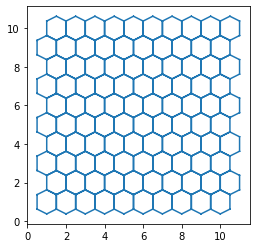

In [6]:
fig, ax = quick_edge_draw(sheet)

In [7]:
from scipy.interpolate import splprep, splev

Bernstein curve code adapted from [@Juanlu001](https://gist.github.com/Juanlu001/7284462)


In [8]:
def quad_bezier(points, density=10):
    p0, p1, p2 = points
    length = ((p1-p0)**2).sum()**0.5 + ((p2-p1)**2).sum()**0.5
    t = np.linspace(0, 1., int(np.ceil(density*length)))[:, np.newaxis]
    return (1-t)**2 * p0 + 2*t * (1-t) * p1 + t**2 * p2


def _face_bezier(pl, shrink=None, density=10):
    pl = pl.astype(np.float)
    pl = np.concatenate((pl, pl[0, np.newaxis]))
    if shrink is not None:
        center = pl.mean(axis=0)[np.newaxis, :]
        length = np.linalg.norm((pl-center), axis=1)[:, np.newaxis]
        pl = (pl - center) * (1  - shrink/length) + center
    pl_mid = (pl[:-1:] + pl[1::])/2
    pl_mid = np.concatenate(
        (pl_mid[-1, np.newaxis], pl_mid))
    curves = np.concatenate(
        [quad_bezier(points, density) for points
         in zip(pl_mid[:-1:], pl[:-1:], pl_mid[1::])])
    
    return curves


In [9]:
from tyssue.io import hdf5
from tyssue import config, SheetGeometry
import json

dsets = hdf5.load_datasets(
    '../data/hf5/small_ellipsoid.hf5',
    data_names=['vert', 'edge', 'face'])

#specs = {k:specs[k] for k in specs if k != 'cell'}
sheet = Sheet('ellipse', dsets, config.geometry.cylindrical_sheet())
sheet.face_df['mask'] = (sheet.face_df.segment=='apical')
sheet = sheet.extract('mask')

In [10]:
polys = sheet.face_polygons(['x', 'y', 'z'])


In [ ]:
curves = []
for s in np.linspace(0, 0.01, 5):
    SheetGeometry.scale(sheet, (1 + s), sheet.coords)
    SheetGeometry.update_all(sheet)
    polys = sheet.face_polygons(['x', 'y', 'z'])
    curves.append(polys.apply(_face_bezier, shrink=0.1-s, density=200))
    SheetGeometry.scale(sheet, 1/(1 + s), sheet.coords)
    
    SheetGeometry.scale(sheet, (1 - s), sheet.coords)
    SheetGeometry.update_all(sheet)
    polys = sheet.face_polygons(['x', 'y', 'z'])
    curves.append(polys.apply(_face_bezier, shrink=0.1-s, density=200))
    SheetGeometry.scale(sheet, 1/(1 - s), sheet.coords)


In [8]:
import simuscope


In [9]:
from simuscope import Model
from simuscope import ObjectBuilder

ImportError: cannot import name 'Model' from 'simuscope' (unknown location)

In [10]:
concatenated = np.concatenate([crv for curve in curves for crv in curve])

In [11]:
xy_scale = 0.005
z_scale = 0.02

binned = concatenated*np.array([1/xy_scale, 1/xy_scale, 1/z_scale])[np.newaxis, :]
binned = np.floor(binned).astype(np.int)


In [12]:
binned.min(axis=0)

array([-150, -147,  -59])

In [13]:
intensities = np.random.randint(200, 300, size=binned.shape[0])


In [14]:
binned += np.array([200, 200, 60])[None, :]

In [15]:
stack = np.zeros((400, 400, 128))

In [16]:
binned.shape

(118244, 3)

In [17]:
stack[binned[:, 0], binned[:, 1], binned[:, 2]] = intensities

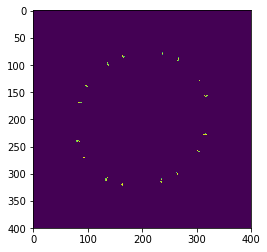

In [18]:
plt.imshow(stack[..., 100])

In [19]:
stack.shape

(400, 400, 128)

In [20]:


model = Model.load_model("no_objects")

model.microscope.camera.chip_size_height = 400
model.microscope.camera.chip_size_width = 400


class TyssueBuilder(ObjectBuilder):
    name = "actin"
    
    def build(self, image, verbose=False):
        channel_indexes = self.get_channel_indexes()
        image[5, channel_indexes, ...] = stack[..., 65]
        return image

builder = model.get_builder()
builder.reset_objects()
builder.add_builder("actin", TyssueBuilder, ["channel_2"], 200, parameters={})

builder.build()
builder.show(frame=5, colormap=None)

NameError: name 'Model' is not defined

In [272]:
builder.image.shape

(10, 2, 400, 400)

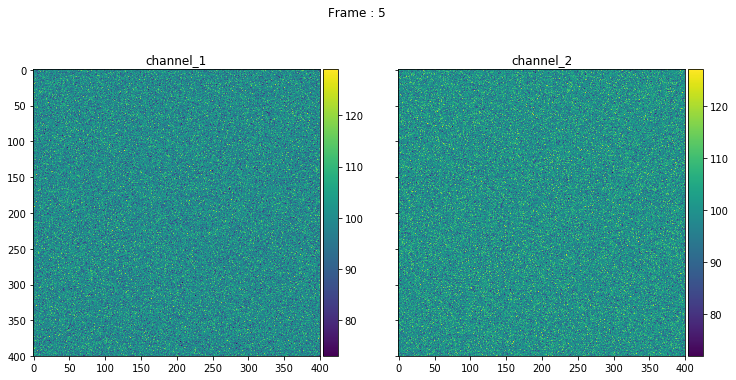

In [221]:
builder.build()
builder.show(frame=5, colormap=None)

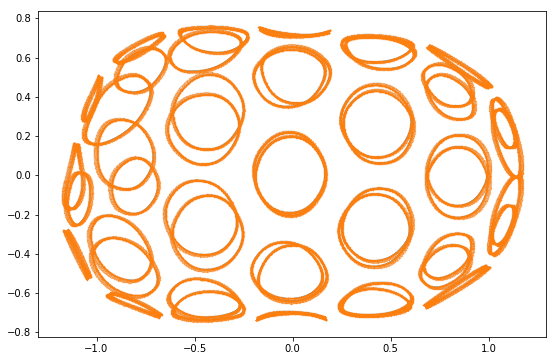

In [21]:
concatenated_d = np.concatenate([np.concatenate([crv, np.zeros((1, 3))*np.nan])
                               for curve in curves for crv in curve])

fig, ax = plt.subplots()
ax.plot(concatenated_d[:, 2],
        concatenated_d[:, 0],
        alpha=0.8, lw=0.1)
ax.plot(concatenated_d[:, 2],
        concatenated_d[:, 0],
        '.', alpha=0.8, ms=0.5)

fig.set_size_inches(16, 6)
ax.set_aspect("equal")

In [24]:
from tyssue.draw.ipv_draw import view_ipv

In [25]:
concatenated.shape

(118244, 3)

In [26]:
%matplotlib qt

In [27]:
ipv.clear()
view_ipv(sheet)

ipv.scatter(*concatenated.T, size=0.3, color='white', marker='box')
ipv.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 0,  1],
       [ 1,  4],
       [ 2,  0],
       [ 3,  2],
       [ 4,  3],
       [ 3,  4],
       [ 5,  3],
       [ 4,  8],
       [ 6,  5],
       [ 7,  6],
       [ 8,  7],
       [ 5,  6],
       [ 9,  5],
       [ 6, 12],
       [10,  9],
       [11, 10],
       [12, 11],
       [11, 12],
       [13, 11],
       [12, 16],
       [14, 13],
       [15, 14],
       [16, 15],
       [13, 14],
       [17, 13],
       [14, 29],
       [18, 17],
       [19, 18],
       [ 4,  1],
       [ 1, 21],
       [ 8,  4],
       [20,  8],
       [21, 20],
       [ 7,  8],
       [22,  7],
       [ 8, 20],
       [20, 24],
       [23, 22],
       [24, 23],
       [ 6,  7],
       [12,  6],
       [ 7, 22],
       [16, 12],
       [25, 16],
       [22, 25],
       [15, 16],
       [26, 15],
       [16, 25],
       [25, 28],
       [27, 26],
       [28, 27],
       [14, 15],
       [29, 14],
       [15, 26],
       [30, 29],
       [26, 30],
       [20, 21],
       [31, 33],
       [24, 20],
       [32, 24],
       [33, 32],
       [23, 24],
       [34, 23],
       [24, 32],
       [32, 36],
       [35, 34],
       [36, 35],
       [22, 23],
       [25, 22],
       [23, 34],
       [28, 25],
       [37, 28],
       [34, 37],
       [27, 28],
       [38, 27],
       [28, 37],
       [37, 40],
       [39, 38],
       [40, 39],
       [26, 27],
       [30, 26],
       [27, 38],
       [41, 30],
       [38, 52],
       [32, 33],
       [42, 44],
       [36, 32],
       [43, 36],
       [44, 43],
       [35, 36],
       [45, 35],
       [36, 43],
       [43, 47],
       [46, 45],
       [47, 46],
       [34, 35],
       [37, 34],
       [35, 45],
       [40, 37],
       [48, 40],
       [45, 48],
       [39, 40],
       [49, 39],
       [40, 48],
       [48, 51],
       [50, 49],
       [51, 50],
       [38, 39],
       [52, 38],
       [39, 49],
       [53, 52],
       [49, 53],
       [43, 44],
       [44, 55],
       [47, 43],
       [54, 47],
       [55, 54],
       [46, 47],
       [56, 46],
       [47, 54],
       [54, 58],
       [57, 56],
       [58, 57],
       [45, 46],
       [48, 45],
       [46, 56],
       [51, 48],
       [59, 51],
       [56, 59],
       [50, 51],
       [60, 50],
       [51, 59],
       [59, 62],
       [61, 60],
       [62, 61],
       [49, 50],
       [53, 49],
       [50, 60],
       [63, 53],
       [60, 74],
       [54, 55],
       [64, 66],
       [58, 54],
       [65, 58],
       [66, 65],
       [57, 58],
       [67, 57],
       [58, 65],
       [65, 69],
       [68, 67],
       [69, 68],
       [56, 57],
       [59, 56],
       [57, 67],
       [62, 59],
       [70, 62],
       [67, 70],
       [61, 62],
       [71, 61],
       [62, 70],
       [70, 73],
       [72, 71],
       [73, 72],
       [60, 61],
       [74, 60],
       [61, 71],
       [75, 74],
       [71, 75],
       [65, 66],
       [66, 77],
       [69, 65],
       [76, 69],
       [77, 76],
       [68, 69],
       [78, 68],
       [69, 76],
       [76, 80],
       [79, 78],
       [80, 79],
       [67, 68],
       [70, 67],
       [68, 78],
       [73, 70],
       [81, 73],
       [78, 81],
       [72, 73],
       [82, 72],
       [73, 81],
       [81, 84],
       [83, 82],
       [84, 83],
       [71, 72],
       [75, 71],
       [72, 82],
       [85, 75],
       [82, 87],
       [ 0,  2],
       [86,  0],
       [ 2, 80],
       [76, 77],
       [80, 76],
       [ 2,  3],
       [80,  2],
       [ 3,  5],
       [ 5,  9],
       [ 9, 79],
       [79, 80],
       [ 9, 10],
       [79,  9],
       [10, 84],
       [78, 79],
       [81, 78],
       [84, 81],
       [10, 11],
       [84, 10],
       [11, 13],
       [13, 